In [2]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
import pickle
import spliland
import importlib
import random
import fclParse
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

Welcome to JupyROOT 6.18/04


In [3]:
directory = './template_data/set_7/'

In [4]:
tf.config.run_functions_eagerly(True)

## Intro

The purpose of this notebook is to make a second attempt at a neural network, following along with what was described in the paper "Deep Learning Based Pulse Shape Analysis for GERDA" by Philipp Holl in 2017. This algorithm consists of an autoencoder, decoder, and then classifier.

I am also following this guide: https://keras.io/examples/timeseries/timeseries_anomaly_detection/ for the implementation of the layers described in the paper into python

### Prep the data

In [5]:
n_points = 8000

with open(directory + 'x_train.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_train = []
    for x in biggestX[:n_points]:
        x_train.append(x[1])
    xFile.close()
    
with open(directory + 'x_test.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_test = []
    for x in biggestX[:2000]:
        x_test.append(x[1])
    xFile.close()

with open(directory + 'y_train.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_train = biggestY[:n_points]
    yFile.close()
    
with open(directory + 'y_test.data', 'rb') as yFile:
    biggestY = pickle.load(yFile)
    y_test = biggestY[:2000]
    yFile.close()
    
with open(directory + 'x_delta_train.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_delta_train = []
    for x in biggestX[:n_points]:
        x_delta_train.append(x[1])
    xFile.close()
    
with open(directory + 'x_delta_test.data', 'rb') as xFile:
    biggestX = pickle.load(xFile)
    x_delta_test = []
    for x in biggestX[:2000]:
        x_delta_test.append(x[1])
    xFile.close()
    
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_delta_train = np.array(x_delta_train)
x_delta_test = np.array(x_delta_test)

In [6]:
X_train = np.reshape(x_train, (n_points, 404, 1))
X_delta_train = np.reshape(x_delta_train, (n_points, 404, 1))

In [7]:
X_train.shape

(8000, 404, 1)

In [8]:
Y_train = np.reshape(y_train, (n_points, 1))

### Autoencoder
As described in the paper, this step consists of a convolutional layer, followed by a fully connected layer to create a feature vector. In keras, a fully connected layer is called a dense layer

In [16]:
encoder_model = keras.Sequential([
    keras.layers.Input(shape=(x_train.shape[1], 1)),
    # encoding
    keras.layers.Conv1D(filters=1, kernel_size=9, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Dense(50, activation='relu'),

    # decoding
    keras.layers.Dense(50, activation='relu'),
    keras.layers.UpSampling1D(size=4),
    keras.layers.Conv1DTranspose(filters=1, kernel_size=9, activation='relu')
])

In [17]:
encoder_model.compile(optimizer = 'adam', loss='mse')

In [18]:
history = encoder_model.fit(X_train, X_train, epochs=50,
                            batch_size=128, validation_split=0.2)

Epoch 1/50
 3/50 [>.............................] - ETA: 1s - loss: 1.8899e-04

/home/lars/miniconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


50/50 [==============================] - 2s 38ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 2/50
50/50 [==============================] - 2s 36ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 3/50
50/50 [==============================] - 2s 41ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 4/50
50/50 [==============================] - 2s 49ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 5/50
50/50 [==============================] - 3s 50ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 6/50
50/50 [==============================] - 2s 50ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 7/50
50/50 [==============================] - 3s 51ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 8/50
50/50 [==============================] - 2s 48ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 9/50
50/50 [==============================] - 2s 49ms/step - loss: 2.0060e-04 - val_loss: 2.0656e-04
Epoch 10/50
50/50 [=============================

In [19]:
x_train_pred = encoder_model.predict(X_train)

In [20]:
x_train_pred.shape

(8000, 404, 1)

2052
4


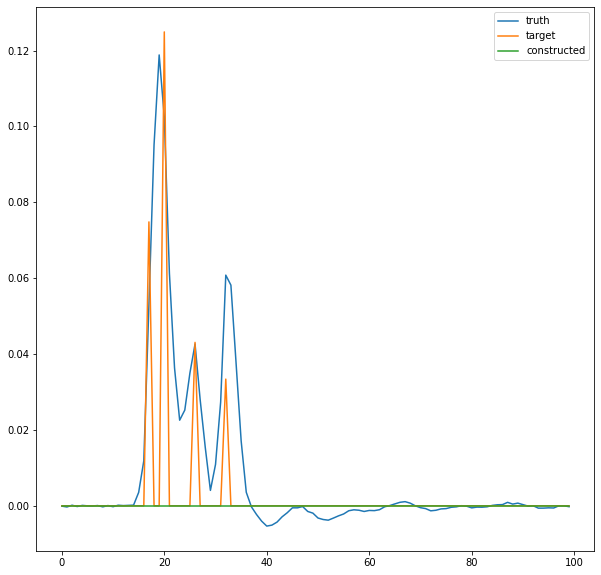

In [23]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)

num = np.random.randint(low=0, high=n_points)
print(num)

print(y_train[num])

ax.plot(x_train[num][:100], label='truth')
ax.plot(x_delta_train[num][:100], label='target')
ax.plot(x_train_pred[num][:100], label='constructed')

plt.legend(loc=0)

### Classifier

In [94]:
classifier_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(404,)),
    keras.layers.Dense(10, activation='relu')
])

In [95]:
classifier_model.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [96]:
X_train_pred = x_train_pred.reshape(n_points, 404)
print(X_train_pred.shape)
print(Y_train.shape)

(8000, 404)
(8000, 1)


In [97]:
classifier_history = classifier_model.fit(X_train_pred,
                                          Y_train,
                                          epochs=50)

Epoch 1/50
 17/250 [=>............................] - ETA: 1s - loss: 2.3007 - accuracy: 0.1287  

/home/lars/miniconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


250/250 [==============================] - 2s 6ms/step - loss: 2.2750 - accuracy: 0.1635
Epoch 2/50
250/250 [==============================] - 2s 6ms/step - loss: 2.2303 - accuracy: 0.1655
Epoch 3/50
250/250 [==============================] - 2s 6ms/step - loss: 2.1650 - accuracy: 0.1655
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 2.1081 - accuracy: 0.1655
Epoch 5/50
250/250 [==============================] - 2s 6ms/step - loss: 2.0722 - accuracy: 0.1655
Epoch 6/50
250/250 [==============================] - 2s 6ms/step - loss: 2.0245 - accuracy: 0.2743
Epoch 7/50
250/250 [==============================] - 2s 6ms/step - loss: 1.9989 - accuracy: 0.3129
Epoch 8/50
250/250 [==============================] - 2s 6ms/step - loss: 1.9876 - accuracy: 0.3169
Epoch 9/50
250/250 [==============================] - 2s 6ms/step - loss: 1.9787 - accuracy: 0.3179
Epoch 10/50
250/250 [==============================] - 2s 6ms/step - loss: 1.9717 - accuracy: 0.3191
Epoch 11/5

In [166]:
classifier_model_2 = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(404,)),
    keras.layers.Dense(10, activation='relu')
])

classifier_model_2.compile(optimizer = 'adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [167]:
classifier_history_2 = classifier_model_2.fit(x_train,
                                            Y_train,
                                            epochs=100)

Epoch 1/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1964 - accuracy: 0.2188
Epoch 2/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1709 - accuracy: 0.2331
Epoch 3/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1483 - accuracy: 0.2383
Epoch 4/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1245 - accuracy: 0.2457
Epoch 5/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.1031 - accuracy: 0.2524
Epoch 6/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.0850 - accuracy: 0.2574
Epoch 7/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.0700 - accuracy: 0.2625
Epoch 8/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.0577 - accuracy: 0.2660
Epoch 9/100
2500/2500 [==============================] - 20s 8ms/step - loss: 2.0476 - accuracy: 0.2690
Epoch 10/100
2500/2500 [==============================] - 20s 8m

### Performance Stats

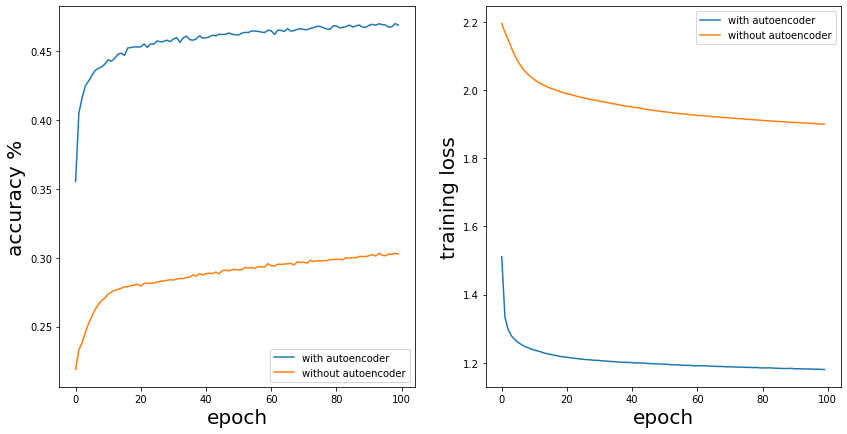

In [168]:
fig, ax = plt.subplots(1,2);
fig.set_size_inches(14,7);

ax[0].plot(classifier_history.history['accuracy'], label='with autoencoder')
ax[0].plot(classifier_history_2.history['accuracy'], label='without autoencoder')

ax[0].set_xlabel("epoch", fontsize=20)
ax[0].set_ylabel("accuracy %", fontsize=20)
ax[0].legend()

ax[1].plot(classifier_history.history['loss'], label='with autoencoder')
ax[1].plot(classifier_history_2.history['loss'], label='without autoencoder')

ax[1].set_xlabel("epoch", fontsize=20)
ax[1].set_ylabel("training loss", fontsize=20)
ax[1].legend()

In [55]:
Y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

matrix = confusion_matrix(y_test, y_pred, normalize='true', labels=[1,2,3,4,5,6])

"""
Y_pred_2 = classifier_model_2.predict(x_test)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

matrix_2 = confusion_matrix(y_test, y_pred_2, normalize='true', labels=[1,2,3,4,5,6])
"""

"\nY_pred_2 = classifier_model_2.predict(x_test)\ny_pred_2 = np.argmax(Y_pred_2, axis=1)\n\nmatrix_2 = confusion_matrix(y_test, y_pred_2, normalize='true', labels=[1,2,3,4,5,6])\n"

'\ngrid = np.array(matrix_2)\nim = ax[1].imshow(grid)\n\nfor k in range (0, len(grid)):\n        for l in range (0, len(grid[0])):\n            ax[1].text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color=\'white\')\n            \nax[1].set_xticklabels([\'\'] + labels);\nax[1].set_yticklabels([\'\'] + labels);\n\nax[1].set_ylabel(\'True Pulse Number\', fontsize=20);\nax[1].set_xlabel(\'Classified Pulse Number\', fontsize=20);\n\nax[1].set_title("without autoencoder", fontsize=20)\n'

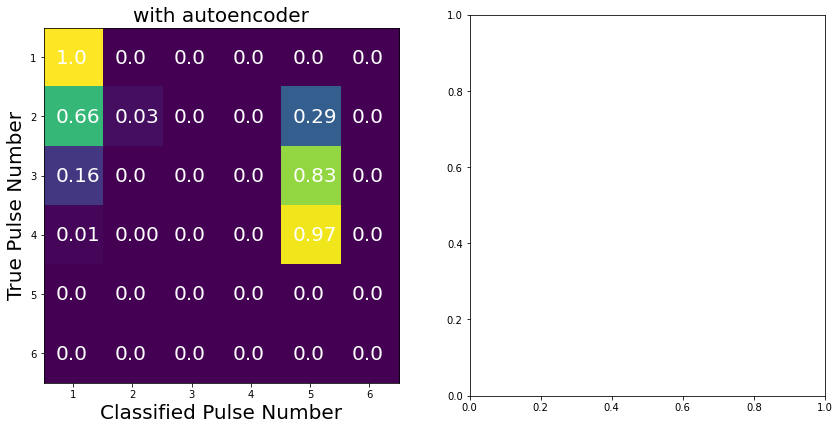

In [56]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14,7)

labels = ['1', '2', '3', '4', '5', '6']

grid = np.array(matrix)
im = ax[0].imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax[0].text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax[0].set_xticklabels([''] + labels);
ax[0].set_yticklabels([''] + labels);

ax[0].set_ylabel('True Pulse Number', fontsize=20);
ax[0].set_xlabel('Classified Pulse Number', fontsize=20);

ax[0].set_title("with autoencoder", fontsize=20)

"""
grid = np.array(matrix_2)
im = ax[1].imshow(grid)

for k in range (0, len(grid)):
        for l in range (0, len(grid[0])):
            ax[1].text(l-0.3, k+0.1, str(grid[k][l])[:4], size=20, color='white')
            
ax[1].set_xticklabels([''] + labels);
ax[1].set_yticklabels([''] + labels);

ax[1].set_ylabel('True Pulse Number', fontsize=20);
ax[1].set_xlabel('Classified Pulse Number', fontsize=20);

ax[1].set_title("without autoencoder", fontsize=20)
"""